In [1]:
# load in the dataset of NSM fitted training data: latent vectors + OA labels
# fit the B-Score to this data

# load in the dataset of NSM fitted testing data: latent vectors + OA labels
# apply the B-Score to this data to get B-Scores

# plot the B-Scores by KL grade & other metrics similar to performed in the
# original B-Score paper

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression


import os

In [3]:
folder_demographics = '/dataNAS/people/aagatti/projects/OAI_DESS/aging_trajectories/data/demographics'
dict_demographic_filenames = {
    'baseline': '0_demographics_baseline.csv',
    '12_month': '1_demographics_12_month.csv',
    '24_month': '3_demographics_24_month.csv',
    '36_month': '5_demographics_36_month.csv',
    '48_month': '6_demographics_48_month.csv',
}

# load in the demographics data from baseline, 12, 24, and 48 months, and get the IDs of subjects (and knees) that are either healthy for all timepoints
# kl = 0, and that had OA for all timepoints (kl >=2)

lists_healthy_IDs = []
lists_OA_IDs = []
lists_no_OA_IDs = []
for timepoint in ['baseline', '12_month', '24_month', '48_month']:
    df = pd.read_csv(os.path.join(folder_demographics, dict_demographic_filenames[timepoint]))
    # create id_knee column so we include all individual knees
    df['id_knee'] = df['id'].astype(int).astype(str) + '_' + df['side'].astype(str)
    
    healthy_IDs = df[df['kl'] == 0]['id_knee'].unique()
    OA_IDs = df[df['kl'] >= 2]['id_knee'].unique()
    no_OA_IDs = df[df['kl'] < 2]['id_knee'].unique()
    lists_healthy_IDs.append(healthy_IDs)
    lists_OA_IDs.append(OA_IDs)
    lists_no_OA_IDs.append(no_OA_IDs)



In [4]:
df_baseline = pd.read_csv(os.path.join(folder_demographics, dict_demographic_filenames['baseline']))
df_baseline['sex'] = df_baseline['sex_1_male_2_female']

In [5]:
print(len(lists_healthy_IDs[0]), len(lists_healthy_IDs[1]), len(lists_healthy_IDs[2]), len(lists_healthy_IDs[3]))
print(len(lists_OA_IDs[0]), len(lists_OA_IDs[1]), len(lists_OA_IDs[2]), len(lists_OA_IDs[3]))

# create a list of health id_knee that appeared in all timepoints
healthy_IDs_all_timepoints = set(lists_healthy_IDs[0]).intersection(lists_healthy_IDs[1], lists_healthy_IDs[2], lists_healthy_IDs[3])
print(f'Number of knees that were healthy at all timepoints: {len(healthy_IDs_all_timepoints)}')

# create a list of OA id_knee that appeared in all timepoints
OA_IDs_all_timepoints = set(lists_OA_IDs[0]).intersection(lists_OA_IDs[1], lists_OA_IDs[2], lists_OA_IDs[3])
print(f'Number of knees that had OA at all timepoints: {len(OA_IDs_all_timepoints)}')

# create a list of knees that progressed from healthy to OA. E.g., in list_healthy_IDs[0], but in list_OA_IDs[3]
list_healthy_to_OA = set(lists_no_OA_IDs[0]).intersection(lists_OA_IDs[3])
print(f'Number of knees that progressed from healthy to OA: {len(list_healthy_to_OA)}')



3440 3113 2893 2522
3888 3802 3612 3325
Number of knees that were healthy at all timepoints: 2301
Number of knees that had OA at all timepoints: 2647
Number of knees that progressed from healthy to OA: 386


In [6]:
print(len(lists_healthy_IDs[0]))
print(len(lists_OA_IDs[3]))
print(len(list_healthy_to_OA))

3440
3325
386


In [7]:
df_baseline['id_side'] = df_baseline['id'].astype(int).astype(str) + '_' + df_baseline['side'].astype(str)

path_df = '/dataNAS/people/aagatti/projects/OAI_DESS/fit_nsm/results/551_nsm_femur_bone_v0.0.1_clipped/1150/00m/latents.pkl'
df_latents = pd.read_pickle(path_df)
df_latents = df_latents.merge(df_baseline, on='id_side', how='left')


In [8]:
df_latents = df_latents.dropna(subset=['kl'])
df_latents = df_latents.dropna(subset=['latent'])
df_latents['healthy'] = df_latents['id_side'].isin(healthy_IDs_all_timepoints)
df_latents['OA'] = df_latents['id_side'].isin(OA_IDs_all_timepoints)
df_latents['progressors'] = df_latents['id_side'].isin(list_healthy_to_OA)
# set all df_latents['progressors'] to nan if kl >= 2
df_latents.loc[df_latents['kl'] >= 2, 'progressors'] = np.nan
latents = df_latents[['latent']]
kl = df_latents[['kl']]
# tka = df_latents[['tkr_incident_108']]
# future_oa = df_latents[['oa_incident_48']]
healthy = df_latents[['healthy']]
OA = df_latents[['OA']]
sex = df_latents[['sex']].values[:,0]
progressors = df_latents[['progressors']].values[:,0].astype(float)


(array([6545.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2290.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

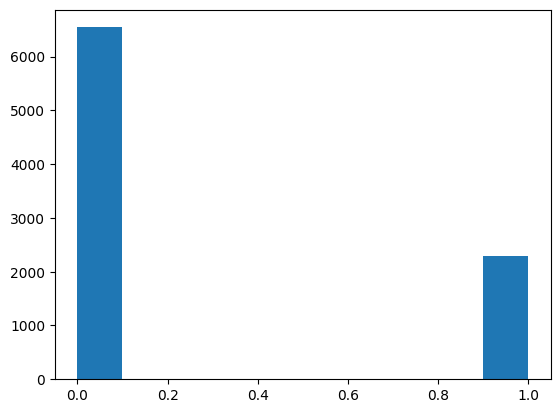

In [9]:
plt.hist(df_latents['healthy'].astype(int))

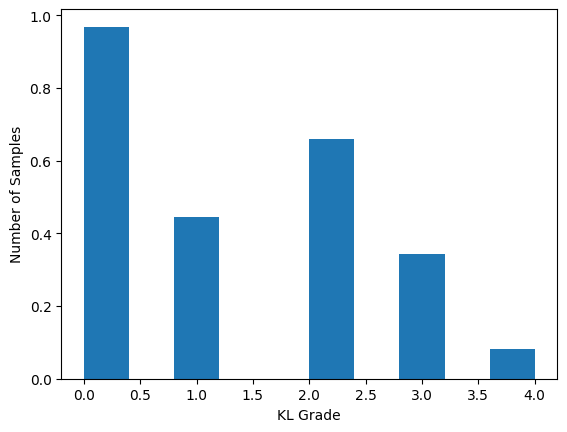

In [10]:
plt.figure()
plt.hist(kl, density=True)
plt.xlabel('KL Grade')
plt.ylabel('Number of Samples')
plt.show()

In [11]:
# print number of finite KL values and the number of values for each KL grade - for the training dataset
print(f'Number of finite KL values: {np.sum(np.isfinite(kl.values))}')
print(f'Number of samples for each KL grade:')
print(kl['kl'].value_counts())




Number of finite KL values: 8835
Number of samples for each KL grade:
kl
0.0    3422
2.0    2335
1.0    1574
3.0    1217
4.0     287
Name: count, dtype: int64


In [12]:
latents.values.shape

(8835, 1)

In [13]:
OA_idx = np.where(OA>0)[0]
control_idx = np.where(healthy>0)[0]

# get the latent vectors for OA and control
# concatenate the latents... 
latents_OA = np.vstack(latents.iloc[OA_idx, 0].values)  # Changed to iloc and .values
latents_control = np.vstack(latents.iloc[control_idx, 0].values)  # Changed to iloc and .values

In [14]:
print(latents_control.shape)
print(latents_OA.shape)

(2290, 512)
(2609, 512)


In [15]:
control_mean = np.mean(latents_control, axis=0)
oa_mean = np.mean(latents_OA, axis=0)

# get b score vector
b_score_vector = oa_mean - control_mean
# normalize
b_score_vector = b_score_vector/np.linalg.norm(b_score_vector)

# get projection of each healthy and OA latent vector onto the disease vector
projection_control = np.dot(latents_control, b_score_vector)
projection_OA = np.dot(latents_OA, b_score_vector)

# get the mean health score (This is our new zero)
mean_control_score = np.mean(projection_control)
# get the SD of the health scores (this is going to be our new unit/1)
sd_control_score = np.std(projection_control, ddof=1)

def get_b_score(latent_vector, b_score_vector, mean_control_score, sd_control_score):
    projection = np.dot(latent_vector, b_score_vector)
    b_score = (projection - mean_control_score)/sd_control_score
    return b_score

all_latents = np.vstack(latents['latent'].values)  # Proper 2D array

# get b-scores for all of the latent vectors
b_scores = get_b_score(all_latents, b_score_vector, mean_control_score, sd_control_score)

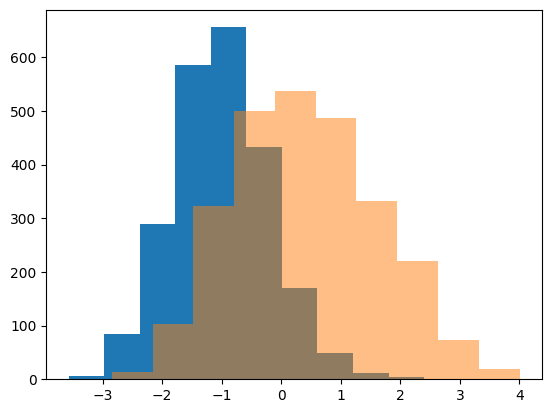

In [16]:
plt.hist(projection_control)
plt.hist(projection_OA, alpha=0.5)
plt.show()


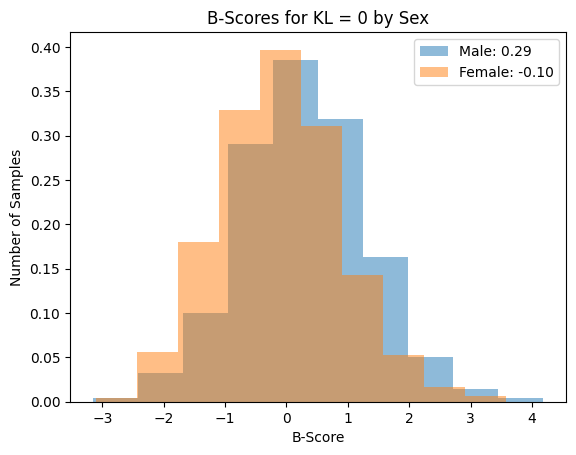

1497 1925


In [17]:
# plot histograms of B-scores by sex for KL = 0
kl_0_idx = np.where(kl == 0)[0]
b_scores_kl_0_male = b_scores[kl_0_idx[np.where(sex[kl_0_idx] == 1)[0]]]
b_scores_kl_0_female = b_scores[kl_0_idx[np.where(sex[kl_0_idx] == 2)[0]]]
mean_b_scores_kl_0_male = np.mean(b_scores_kl_0_male)
mean_b_scores_kl_0_female = np.mean(b_scores_kl_0_female)
plt.hist(b_scores_kl_0_male, density=True, alpha=0.5, label=f'Male: {mean_b_scores_kl_0_male:.2f}')
plt.hist(b_scores_kl_0_female, density=True, alpha=0.5, label=f'Female: {mean_b_scores_kl_0_female:.2f}')
plt.xlabel('B-Score')
plt.ylabel('Number of Samples')
plt.title('B-Scores for KL = 0 by Sex')
plt.legend()
plt.show()
print(len(b_scores_kl_0_male), len(b_scores_kl_0_female))


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


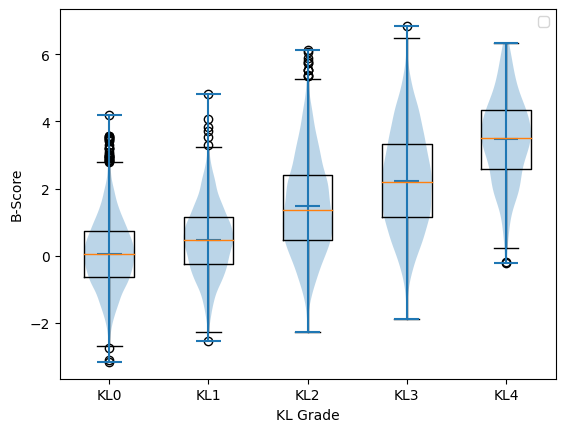

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


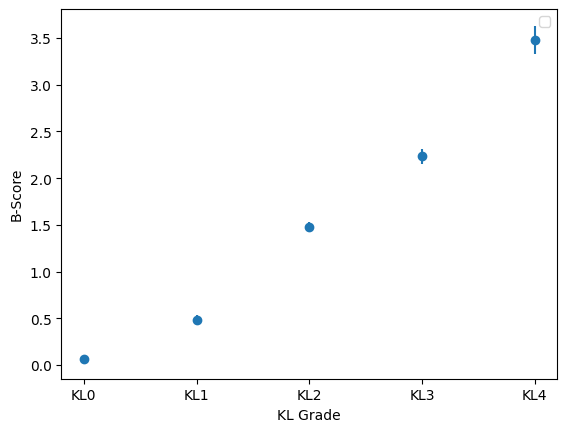

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


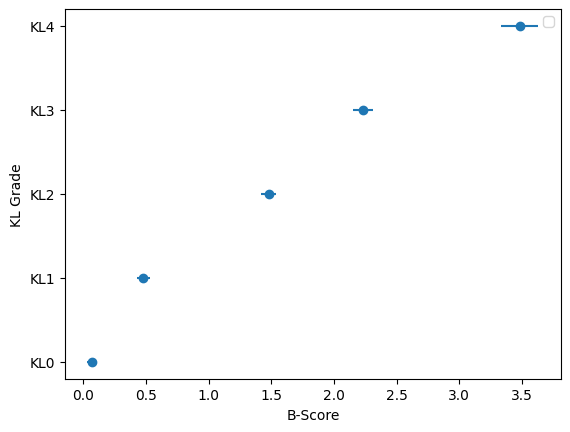

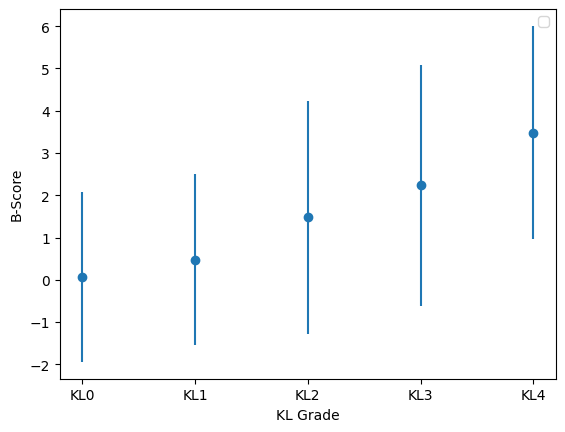

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


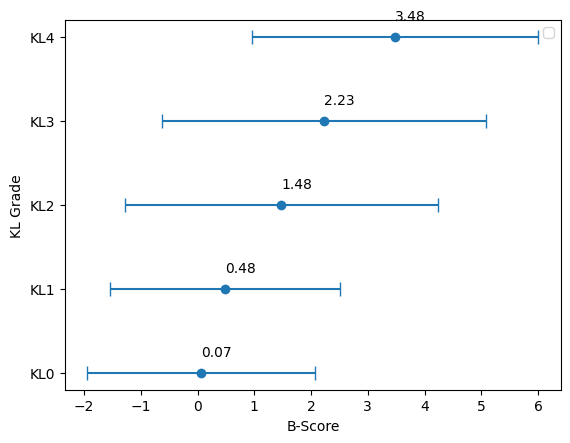

In [18]:
# plot the B-Scores by KL grade - create one box/violinplot for each KL grade
# the KL grades are 0, 1, 2, 3, 4
plt.figure()
b_scores_ = []
for kl_grade in range(5):
    kl_idx = np.where(kl == kl_grade)[0]
    projection_kl = b_scores[kl_idx]
    b_scores_.append(projection_kl)

plt.boxplot(b_scores_)
plt.violinplot(b_scores_, showmeans=True)
plt.xticks([1,2,3,4,5],['KL0','KL1','KL2','KL3','KL4'])
plt.xlabel('KL Grade')
plt.ylabel('B-Score')
plt.legend()
plt.show()

# create another plot that shows the mean B-Score and its 95% CI for each KL grade
# include an annotation with the mean 

plt.figure()
b_scores_ = []
for kl_grade in range(5):
    kl_idx = np.where(kl == kl_grade)[0]
    projection_kl = b_scores[kl_idx]
    b_scores_.append(projection_kl)
mean_b_scores = [np.mean(b_score) for b_score in b_scores_]
# calculate the standard error of the mean/ 
ste_b_scores = [np.std(b_score, ddof=1)/np.sqrt(len(b_score)) * 1.96 for b_score in b_scores_]
plt.errorbar(range(5), mean_b_scores, yerr=ste_b_scores, fmt='o')
plt.xticks([0,1,2,3,4],['KL0','KL1','KL2','KL3','KL4'])
plt.xlabel('KL Grade')
plt.ylabel('B-Score')
plt.legend()
plt.show()

# same as above, but swap the x and y axis - so the error bars are horizontal
plt.figure()
b_scores_ = []
for kl_grade in range(5):
    kl_idx = np.where(kl == kl_grade)[0]
    projection_kl = b_scores[kl_idx]
    b_scores_.append(projection_kl)
mean_b_scores = [np.mean(b_score) for b_score in b_scores_]
# calculate the standard error of the mean/
ste_b_scores = [np.std(b_score, ddof=1)/np.sqrt(len(b_score)) * 1.96 for b_score in b_scores_]
plt.errorbar(mean_b_scores, range(5), xerr=ste_b_scores, fmt='o')
plt.yticks([0,1,2,3,4],['KL0','KL1','KL2','KL3','KL4'])
plt.ylabel('KL Grade')
plt.xlabel('B-Score')
plt.legend()

# Create the same plot but use standard deviation for the 95% CI
plt.figure()
b_scores_ = []
for kl_grade in range(5):
    kl_idx = np.where(kl == kl_grade)[0]
    projection_kl = b_scores[kl_idx]
    b_scores_.append(projection_kl)
mean_b_scores = [np.mean(b_score) for b_score in b_scores_]
# calculate the standard deviation
std_b_scores = [np.std(b_score, ddof=1)*1.96 for b_score in b_scores_]
plt.errorbar(range(5), mean_b_scores, yerr=std_b_scores, fmt='o')
plt.xticks([0,1,2,3,4],['KL0','KL1','KL2','KL3','KL4'])
plt.xlabel('KL Grade')
plt.ylabel('B-Score')
plt.legend()
plt.show()

# plot the above horizontally
plt.figure()
b_scores_ = []
for kl_grade in range(5):
    kl_idx = np.where(kl == kl_grade)[0]
    projection_kl = b_scores[kl_idx]
    b_scores_.append(projection_kl)
mean_b_scores = [np.mean(b_score) for b_score in b_scores_]
# calculate the standard deviation
std_b_scores = [np.std(b_score, ddof=1)*1.96 for b_score in b_scores_]
# plot error bars, with endcaps
plt.errorbar(mean_b_scores, range(5), xerr=std_b_scores, fmt='o', capsize=5)
plt.yticks([0,1,2,3,4],['KL0','KL1','KL2','KL3','KL4'])
# print the mean B-Score for each KL grade dor - just above it and to the right 
# on the plot
for idx, kl_grade in enumerate(range(5)):
    plt.text(mean_b_scores[idx], kl_grade+0.2, f'{mean_b_scores[idx]:.2f}')
plt.ylabel('KL Grade')
plt.xlabel('B-Score')
plt.legend()
plt.show()


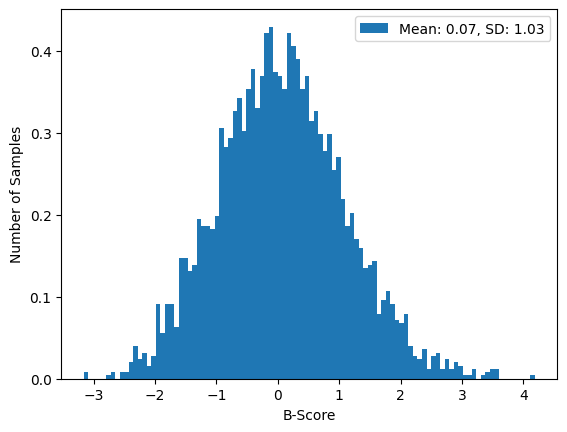

In [19]:
# plot a histogram of the B-Scores for KL = 0
# compute the mean and std of the B-Scores for KL = 0
kl_0_idx = np.where(kl == 0)[0]
mean_b_scores_kl_0 = np.mean(b_scores[kl_0_idx])
std_b_scores_kl_0 = np.std(b_scores[kl_0_idx], ddof=1)
plt.hist(b_scores[kl_0_idx], bins=100, density=True, label=f'Mean: {mean_b_scores_kl_0:.2f}, SD: {std_b_scores_kl_0:.2f}')
plt.xlabel('B-Score')
plt.ylabel('Number of Samples')
plt.legend()
plt.show()


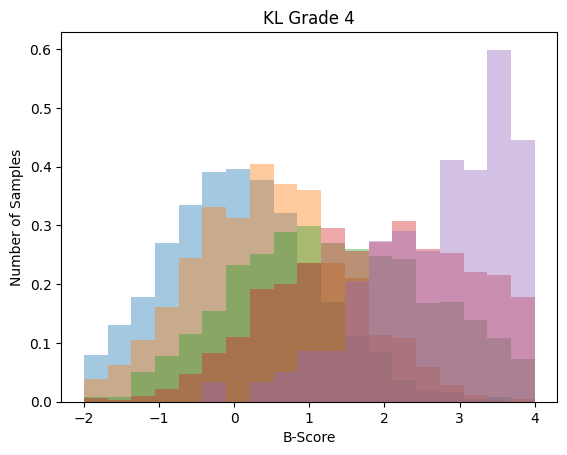

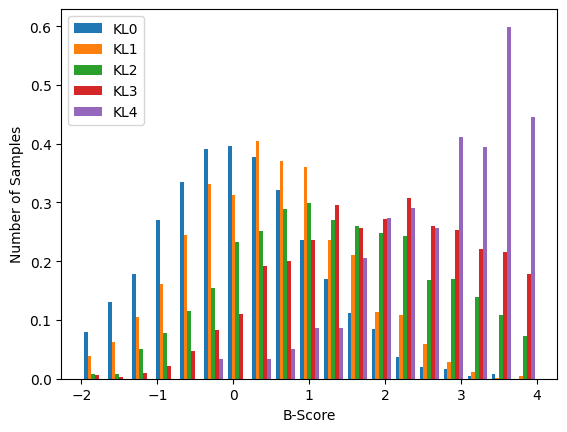

In [20]:
# plot histograms of B-score for each Kl grade
plt.figure()
for idx, kl_grade in enumerate(range(5)):
    plt.hist(b_scores_[idx], bins=np.linspace(-2,4,20), density=True, alpha=0.4)
    plt.title(f'KL Grade {kl_grade}')
    plt.xlabel('B-Score')
    plt.ylabel('Number of Samples')
plt.show()

# plot the histogram of all of the B-Scores
plt.figure()
plt.hist(b_scores_, bins=np.linspace(-2,4,20), density=True)
# add labels for different b-scores being plotted in hist. (kl0, kl1, kl2, kl3, kl4)
plt.legend(['KL0', 'KL1', 'KL2', 'KL3', 'KL4'])
plt.xlabel('B-Score')
plt.ylabel('Number of Samples')
plt.show()


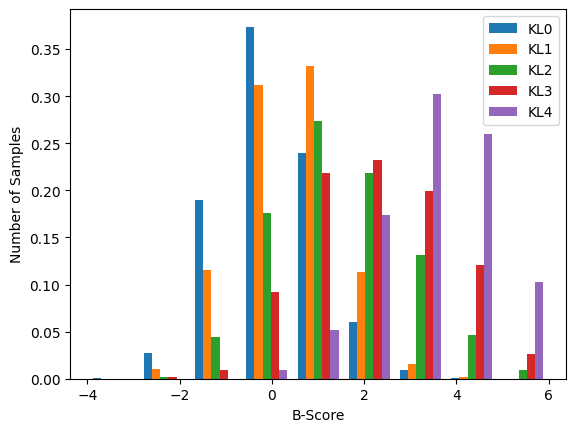

In [21]:
# plot the histogram of all of the B-Scores
plt.figure()
plt.hist(b_scores_, bins=np.linspace(-4,6,10), density=True)
# add labels for different b-scores being plotted in hist. (kl0, kl1, kl2, kl3, kl4)
plt.legend(['KL0', 'KL1', 'KL2', 'KL3', 'KL4'])
plt.xlabel('B-Score')
plt.ylabel('Number of Samples')
plt.show()

In [22]:
#print the key metrics about distribution of B-Scores per KL grade
for idx, kl_grade in enumerate(range(5)):
    print(f'KL Grade {kl_grade}:')
    print(f'\tMean B-Score: {mean_b_scores[idx]:.2f}')
    print(f'\tStandard Deviation: {std_b_scores[idx]:.2f}')
    print(f'\tMinimum B-Score: {np.min(b_scores_[idx]):.2f}')
    print(f'\tMaximum B-Score: {np.max(b_scores_[idx]):.2f}')
    print(f'\tNumber of Samples: {len(b_scores_[idx])}')


KL Grade 0:
	Mean B-Score: 0.07
	Standard Deviation: 2.01
	Minimum B-Score: -3.16
	Maximum B-Score: 4.19
	Number of Samples: 3422
KL Grade 1:
	Mean B-Score: 0.48
	Standard Deviation: 2.03
	Minimum B-Score: -2.54
	Maximum B-Score: 4.82
	Number of Samples: 1574
KL Grade 2:
	Mean B-Score: 1.48
	Standard Deviation: 2.76
	Minimum B-Score: -2.27
	Maximum B-Score: 6.13
	Number of Samples: 2335
KL Grade 3:
	Mean B-Score: 2.23
	Standard Deviation: 2.86
	Minimum B-Score: -1.87
	Maximum B-Score: 6.84
	Number of Samples: 1217
KL Grade 4:
	Mean B-Score: 3.48
	Standard Deviation: 2.53
	Minimum B-Score: -0.20
	Maximum B-Score: 6.34
	Number of Samples: 287


In [23]:
# # run logistic regression predicting total knee replacement from B-score
# # then plot the results with the x-axis being the B-Score and the y-axis being 
# # the probability of TKA

# # fit the LR model on the training data & apply it to the testing data
# # use the train/test data from above
# # and make the plots based on the model in general. 
# # Then, determine how well the model does by assessing it on the testing data

# # fit the model
# lr = LogisticRegression()
# lr.fit(b_scores.reshape(-1,1), tka)
# # get probabilites for fixed intervals of the B-Score from -2 to 4
# _b_scores_ = np.linspace(-2,np.max(b_scores),100).reshape(-1,1)
# probs = lr.predict_proba(_b_scores_)
# # make the plot
# plt.figure()
# plt.plot(_b_scores_, probs[:,1])
# # add grey bars from -2 to 2 to show the range of the B-Score in healthies
# plt.axvspan(-2,2, color='grey', alpha=0.5)
# plt.xlabel('B-Score')
# plt.ylabel('Probability of TKA')
# plt.show()


In [24]:
progressors.astype(float)

array([nan,  0.,  0., ...,  0., nan,  0.])

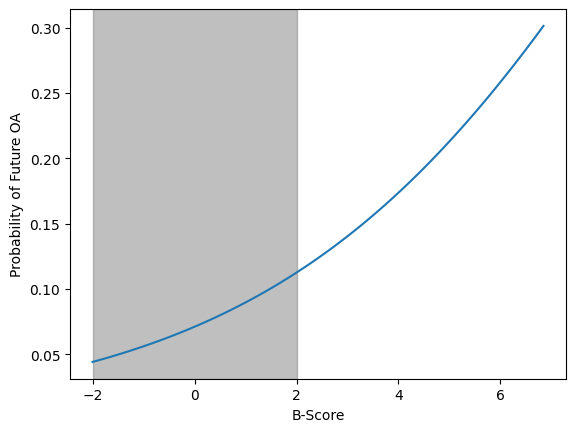

In [25]:
# run logistic regression for future OA

# fit the model
lr = LogisticRegression()
lr.fit(b_scores[np.where(np.isfinite(progressors))[0]].reshape(-1,1), progressors[np.where(np.isfinite(progressors))[0]])
# get probabilites for fixed intervals of the B-Score from -2 to 4
_b_scores_ = np.linspace(-2,np.max(b_scores),100).reshape(-1,1)
probs = lr.predict_proba(_b_scores_)
# make the plot
plt.figure()
plt.plot(_b_scores_, probs[:,1])
# add grey bars from -2 to 2 to show the range of the B-Score in healthies
plt.axvspan(-2,2, color='grey', alpha=0.5)
plt.xlabel('B-Score')
plt.ylabel('Probability of Future OA')
plt.show()


In [26]:
path_save_model = '/dataNAS/people/aagatti/projects/nsm_femur/ShapeMedKnee_BScore/NSM_Orig_BScore_Bone_Only_April_18_2025'
os.makedirs(path_save_model, exist_ok=True)

# save the coefficients
np.save(os.path.join(path_save_model, 'bscore_vector.npy'), b_score_vector)
# save the mean and std of the healthy B-Scores
np.save(os.path.join(path_save_model, 'mean_healthy.npy'), mean_control_score)
np.save(os.path.join(path_save_model, 'std_healthy.npy'), sd_control_score)

# control_mean = np.mean(latents_control, axis=0)
# oa_mean = np.mean(latents_OA, axis=0)
# save mean control and oa
np.save(os.path.join(path_save_model, 'mean_control_vector.npy'), control_mean)
np.save(os.path.join(path_save_model, 'mean_oa_vector.npy'), oa_mean)

import json 
model_dict = {
    'bscore_vector': b_score_vector.tolist(),
    'mean_healthy': mean_control_score,
    'std_healthy': sd_control_score
}

with open(os.path.join(path_save_model, 'model.json'), 'w') as f:
    json.dump(model_dict, f, indent=4)
